# MNIST Handwritten Digit Classification with Custom Neural Network

A Neural Network is a computational graph structure which consists of layers of nodes called ’neurons’ which have biases and connecting weighted edges called ’synapses’. The concept of the neural network is biologically inspired by the function of a biological brain and replicates its learning capabilities.


> **According to ChatGPT:**
>
> A fully connected neural network, also known as a dense neural network, is a type of neural network in which each neuron in one layer is connected to every neuron in the next layer. This means that the output of each neuron in one layer is used as input for all neurons in the next layer. This allows for a large number of parameters to be learned and for complex non-linear relationships to be modeled. Fully connected neural networks are often used for tasks such as image classification, speech recognition, and natural language processing.

## 🏆 Goal
In this notebook we explore the implementation of a neural network. We will do this by building and training a neural network to classify images of handwritten digits from the MNIST dataset.

<center>
    <figure>
        <img src="https://i.postimg.cc/ZqsJckVV/ANN.gif" alt ="Artificial Neural Network" style='width: 600px;'>
        <figcaption>
            GIF Source: <a href="https://gfycat.com/bitesizedweeblacklemur">[Source]</a></figcaption>
    </figure>
</center>

## 📁 Dataset
The MNIST database is a large database consisting of 28x28 handwritten digit images that is commonly used for training various computer vision models. It contains 60,000 training images and 10,000 testing images. 

### For more information check out the following links:
> - [Original MNIST Database](http://yann.lecun.com/exdb/mnist/)
> - [Kaggle: MNIST Dataset](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv)

### Note:
> - The development of this project is currently delayed as I am working on multiple projects at the same time.
> - This notebook is still in development! The next updates will cover the addition of educational resources and explanations of the content covered in this notebook.
> - This note will be removed once this notebook is considered to be complete. Thanks for taking the time to view this project.

In [70]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# import required modules
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, top_k_accuracy_score
from scikitplot.metrics import plot_roc

from NeuralNetwork import NeuralNetwork
from NetworkConfigHandler import NetworkConfigHandler
from PreProcessor import PreProcessor
from DataHandler import DataHandler
from ActivationFunctions import ActivationFunctions

# 1. Load Dataset

In [2]:
# Define paths to csv files
mnist_train = '../data/mnist_data/mnist_train.csv'
mnist_test = '../data/mnist_data/mnist_test.csv'

In [3]:
# Initialise feature and label columns
delimiter = ','
features = [f'pixel_{i}' for i in range(784)]
targets = ['id']
column_names = targets + features

In [4]:
# Load the csv files
train_df = PreProcessor.load_data(mnist_train, column_names=column_names)
test_df = PreProcessor.load_data(mnist_test, column_names=column_names)

Reading data from ../data/mnist_data/mnist_train.csv
Reading data from ../data/mnist_data/mnist_test.csv


In [5]:
# View the first 10 samples from the training set
train_df.head(10)

,id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# View the first 10 samples from the test set
test_df

,id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create train-validation split

In [7]:
# use 40% of the training set for testing the framework 
# remove the line below to use the full training set 
train_df = train_df.sample(frac=.4)

# Create train-validation splits
train_df, val_df = PreProcessor.split_dataset(train_df, 0.2, seed=42)
train_df.shape, val_df.shape

((19200, 785), (4800, 785))

In [8]:
# Preprocess training data  
X_train = PreProcessor.normalize_dataset(train_df.loc[:, features].to_numpy())
y_train = train_df.loc[:, targets].to_numpy()

# Preprocess validation data 
X_val = PreProcessor.normalize_dataset(val_df.loc[:, features].to_numpy())
y_val = val_df.loc[:, targets].to_numpy()

# Preprocess test data 
X_test = PreProcessor.normalize_dataset(test_df.loc[:, features].to_numpy())
y_test = test_df.loc[:, targets].to_numpy()

### Encode targets

In [9]:
# Define one-hot encoder
encoder = OneHotEncoder(sparse=False)

# Fit encoder and transform training labels
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))

# Transform validation and testing labels
y_val_one_hot = encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))

In [28]:
# View training label sample
idx = random.randint(0, len(X_train))
print('Label:', y_train[idx])
print('One-hot Encoding:', y_train_one_hot[idx])
print('One-hot shape:', y_train_one_hot.shape)

Label: [8]
One-hot Encoding: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
One-hot shape: (19200, 10)


### View Sample Image

In [19]:
def plot_digit(digit, label=None):
    plt.imshow(digit.reshape(28, 28), cmap='gray')
    if label != None:
        plt.title(f'Digit: {label}')
    plt.show()

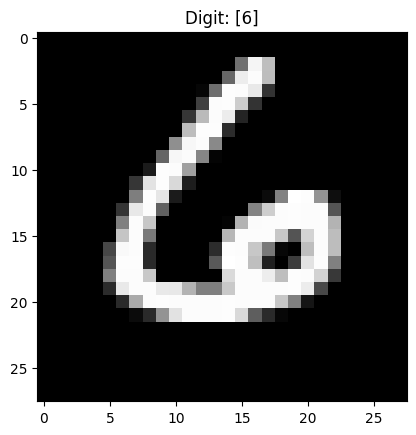

In [21]:
# Plot random training sample
idx = random.randint(0, len(X_train))
plot_digit(X_train[idx], y_train[idx])

# 2. Create Input Data Pipeline with DataHandler

In [31]:
# Create training input pipeline
train_ds = DataHandler(X_train, y_train_one_hot, shuffle=True)

# Create validation input pipeline
val_ds = DataHandler(X_val, y_val_one_hot)

# Create test input pipeline
test_ds = DataHandler(X_test, y_test_one_hot)

In [32]:
# View pipeline input & target shapes
print(train_ds.X.shape, train_ds.y.shape)
print(val_ds.X.shape, val_ds.y.shape)
print(test_ds.X.shape, test_ds.y.shape)

(19200, 784) (19200, 10)
(4800, 784) (4800, 10)
(10000, 784) (10000, 10)


# 3. Build Neural Network

In [107]:
# initialise neural network parameters
input_size = len(features) # size of input
alpha = 3 # learning rate
model_config = [
    {'units': input_size, 'activation': 'input'},
    {'units': 512, 'activation': 'relu'},
    {'units': 256, 'activation': 'leaky_relu'},
    {'units': 10, 'activation': 'sigmoid'}
]

In [108]:
# construct neural network
model = NeuralNetwork(model_config, alpha)

### Train Model

In [109]:
#train neural network
epochs = 5
model.fit(train_ds, val_ds, epochs)

Data received -> Training initiated...
Epoch 1/5


100%|██████████| 19200/19200 [01:39<00:00, 193.25it/s]


cost: 9.259983			accuracy: 0.750729
val_cost: 9.98364		val_accuracy: 0.743542
-------------------------------------------------
Epoch 2/5


100%|██████████| 19200/19200 [01:42<00:00, 188.23it/s]


cost: 9.19885			accuracy: 0.804583
val_cost: 9.458679		val_accuracy: 0.784792
-------------------------------------------------
Epoch 3/5


100%|██████████| 19200/19200 [01:40<00:00, 191.68it/s]


cost: 9.192146			accuracy: 0.818073
val_cost: 9.673781		val_accuracy: 0.784375
-------------------------------------------------
Epoch 4/5


100%|██████████| 19200/19200 [01:41<00:00, 189.18it/s]


cost: 9.181242			accuracy: 0.822187
val_cost: 9.561934		val_accuracy: 0.806458
-------------------------------------------------
Epoch 5/5


100%|██████████| 19200/19200 [01:30<00:00, 212.05it/s]


cost: 9.176416			accuracy: 0.825104
val_cost: 9.997906		val_accuracy: 0.771458
-------------------------------------------------


# 4. Inspect Model Performance

In [110]:
# Evaluate model on test set
cost, acc = model.evaluate(test_ds)
print('Test Cost:', cost)
print('Test Accuracy:', f'{round(acc * 100, 2)}%')

Test Cost: 9.962950305021211
Test Accuracy: 77.98%


In [111]:
# Generate test prediction probabilities
test_probabilities = model.predict(test_ds)
test_probabilities.shape

(10000, 10, 1)

In [112]:
# Generate test prediction labels
test_predictions = np.argmax(test_probabilities, axis=1)
test_predictions.shape

(10000, 1)

In [113]:
# View model cost history
print('Train_cost:',model.cost_hist['Train_cost'])
print('Validation_cost:',model.cost_hist['Validation_cost'])

Train_cost: [9.259982824342915, 9.198849687147112, 9.19214645964585, 9.181242358542248, 9.176415664083542]
Validation_cost: [9.983639651241093, 9.45867895728393, 9.673780753304259, 9.561933634098374, 9.997905852259503]


### Plot Model Training History

In [114]:
# combine model history into one record
model_history = {
    'accuracy':         model.accuracies['Train_set'],
    'val_accuracy':     model.accuracies['Validation_set'],
    'cost':             model.cost_hist['Train_cost'],
    'val_cost':     model.cost_hist['Validation_cost']
}
model_history

{'accuracy': [0.7507291666664914,
  0.804583333333109,
  0.8180729166664301,
  0.8221874999997597,
  0.8251041666664237],
 'val_accuracy': [0.7435416666666667,
  0.7847916666666667,
  0.784375,
  0.8064583333333334,
  0.7714583333333334],
 'cost': [9.259982824342915,
  9.198849687147112,
  9.19214645964585,
  9.181242358542248,
  9.176415664083542],
 'val_cost': [9.983639651241093,
  9.45867895728393,
  9.673780753304259,
  9.561933634098374,
  9.997905852259503]}

In [115]:
def plot_training_curves(history):
    
    cost = np.array(history['cost'])
    val_cost = np.array(history['val_cost'])

    accuracy = np.array(history['accuracy'])
    val_accuracy = np.array(history['val_accuracy'])

    epochs = range(len(history['cost']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, cost, label='training_loss', marker='o')
    ax1.plot(epochs, val_cost, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, cost, val_cost, where=(cost > val_cost), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, cost, val_cost, where=(cost < val_cost), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Cost (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();


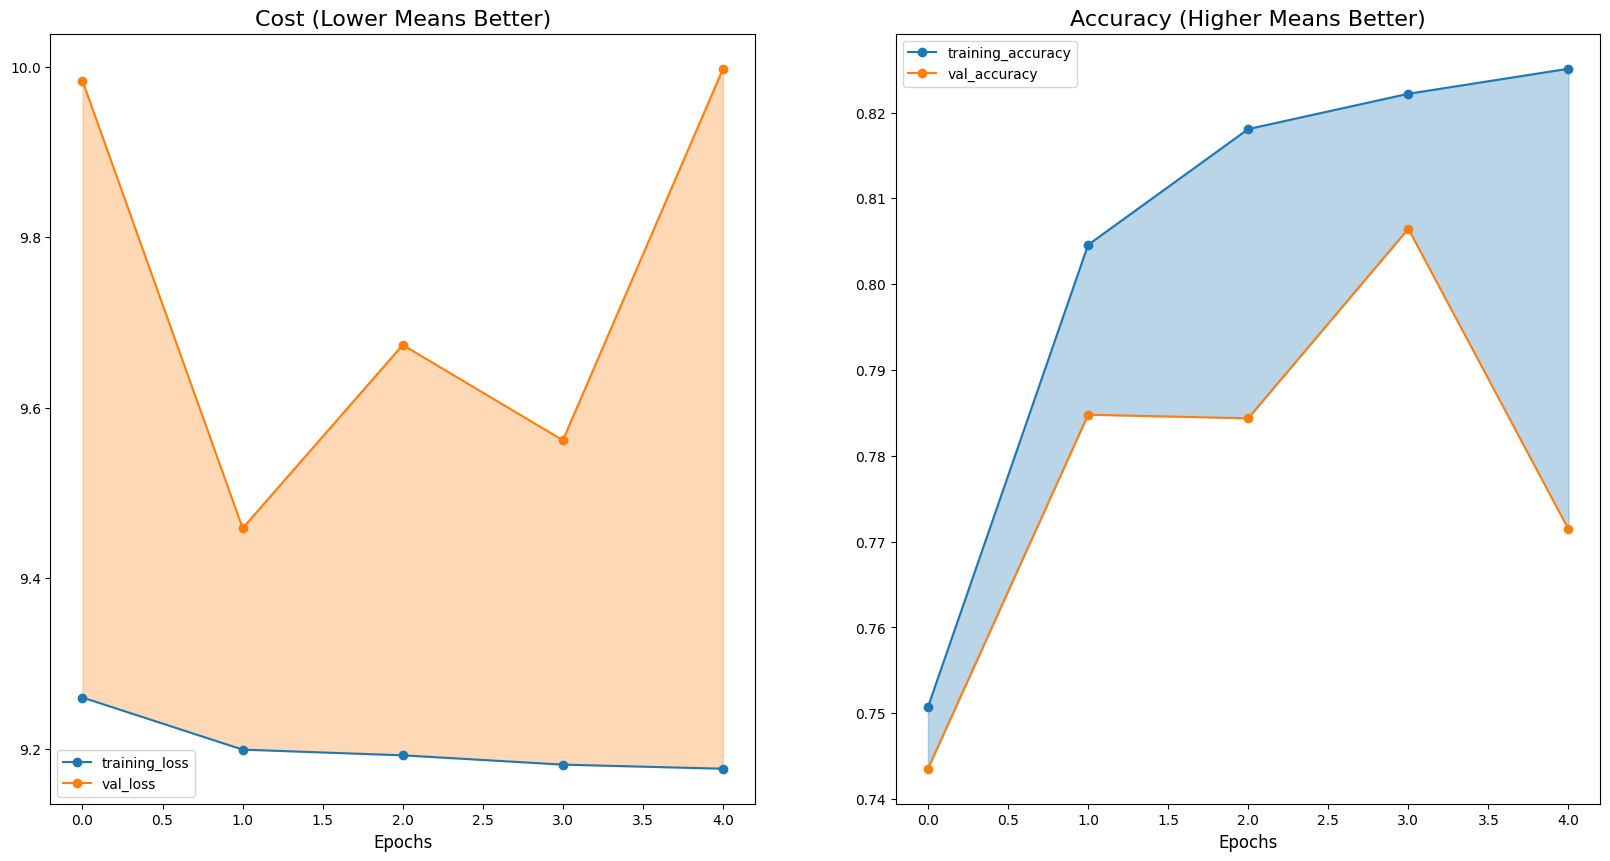

In [116]:
# Plot training history
plot_training_curves(model_history)

### Plot Model ROC Curves

In [117]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=12, norm=False, savefig=False): 

    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Greens) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes), # create enough axis slots for each class
        yticks=np.arange(n_classes), 
        xticklabels=labels, # axes will labeled with class names (if they exist) or ints
        yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.
    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(
                j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(
                j, i, f"{cm[i, j]}",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

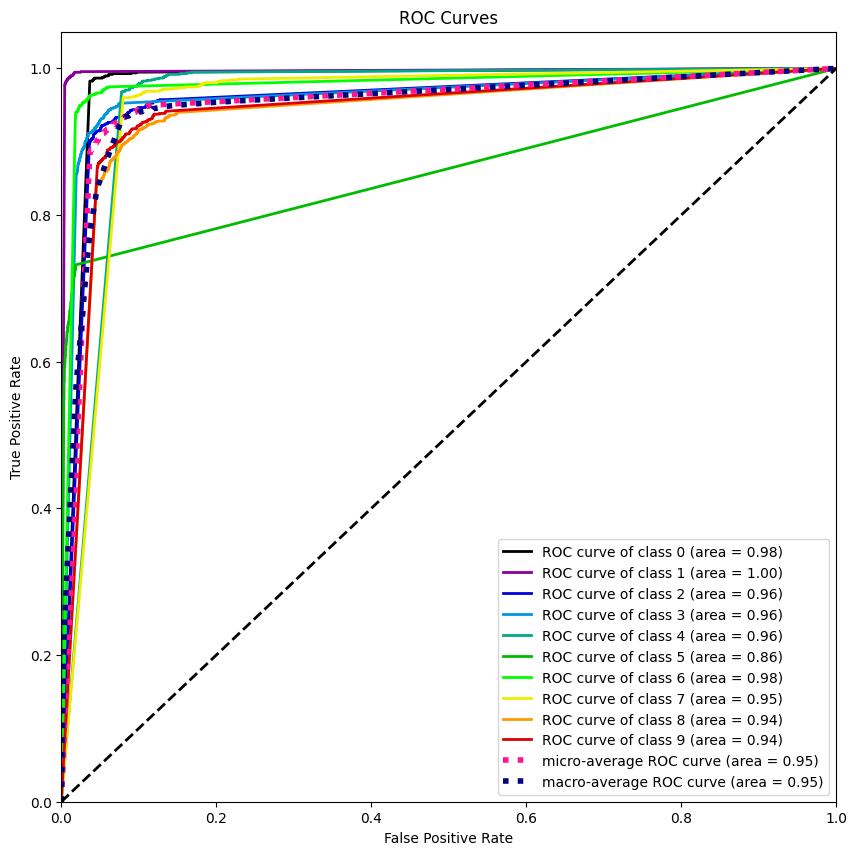

In [118]:
# View ROC Curve
plot_roc(
    y_test, 
    test_probabilities, 
    figsize=(10, 10), 
    title_fontsize='large');

### Inspect Confusion Matrix

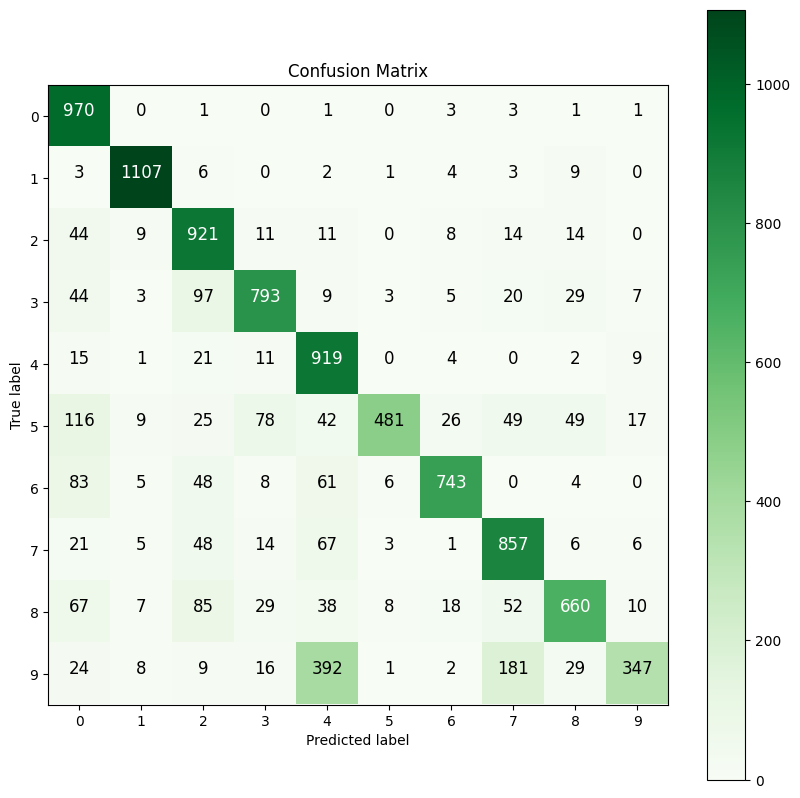

In [119]:
# View confusion matrix
generate_confusion_matrix(y_test, test_predictions)

### View Classification Report

In [120]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.70      0.99      0.82       980
           1       0.96      0.98      0.97      1135
           2       0.73      0.89      0.80      1032
           3       0.83      0.79      0.81      1010
           4       0.60      0.94      0.73       982
           5       0.96      0.54      0.69       892
           6       0.91      0.78      0.84       958
           7       0.73      0.83      0.78      1028
           8       0.82      0.68      0.74       974
           9       0.87      0.34      0.49      1009

    accuracy                           0.78     10000
   macro avg       0.81      0.77      0.77     10000
weighted avg       0.81      0.78      0.77     10000



### Inspect Model Metrics

In [121]:
def generate_performance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    # top_3_accuracy = round(top_k_accuracy_score(y_true, y_probabilities, k=2), 5)
    model_precision, model_recall, model_f1, _ = \
        precision_recall_fscore_support(y_true, y_pred, average="weighted")

    model_precision, model_recall, model_f1 = \
        round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)
    
    model_matthews_corrcoef = round(matthews_corrcoef(y_true, y_pred), 5)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('_____________________________________________')
    # print(f'top_3_accuracy_score:\t{top_3_accuracy}\n')
    # print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')
    print('=============================================')
    
    return


In [122]:
# View performance scores
generate_performance_scores(y_test, test_predictions, test_probabilities)


Performance Metrics:

accuracy_score:		0.7798

_____________________________________________
precision_score:	0.81046

_____________________________________________
recall_score:		0.7798

_____________________________________________
f1_score:		0.76967

_____________________________________________
matthews_corrcoef:	0.75993



### View Test Sample Predictions

In [123]:
def display_digits(neural_network, X_data, y_data, img_count):
    fig = plt.figure(figsize=(14, 14))

    for i in range(1, img_count + 1):
        idx = random.randint(0, len(X_data) - 1)
        img = np.reshape(X_data[idx], (np.shape(X_data[idx])[0], 1))
        id = y_data[idx]
        
        output = neural_network.forward_propagate(img)
        prediction = np.argmax(output, axis=0)

        prob = output[int(prediction)]
        pixels = img.reshape((28, 28))
        plt.subplot(4, 5, i)
        
        plt.imshow(pixels, cmap='gray')
        plt.title(f'True Label: {id}')
        plt.xlabel(f'NN prediction: {prediction}\nProbability: {round(prob[0], 8)}') 

    plt.subplots_adjust(wspace=0.9, hspace=0.9)
    plt.show()

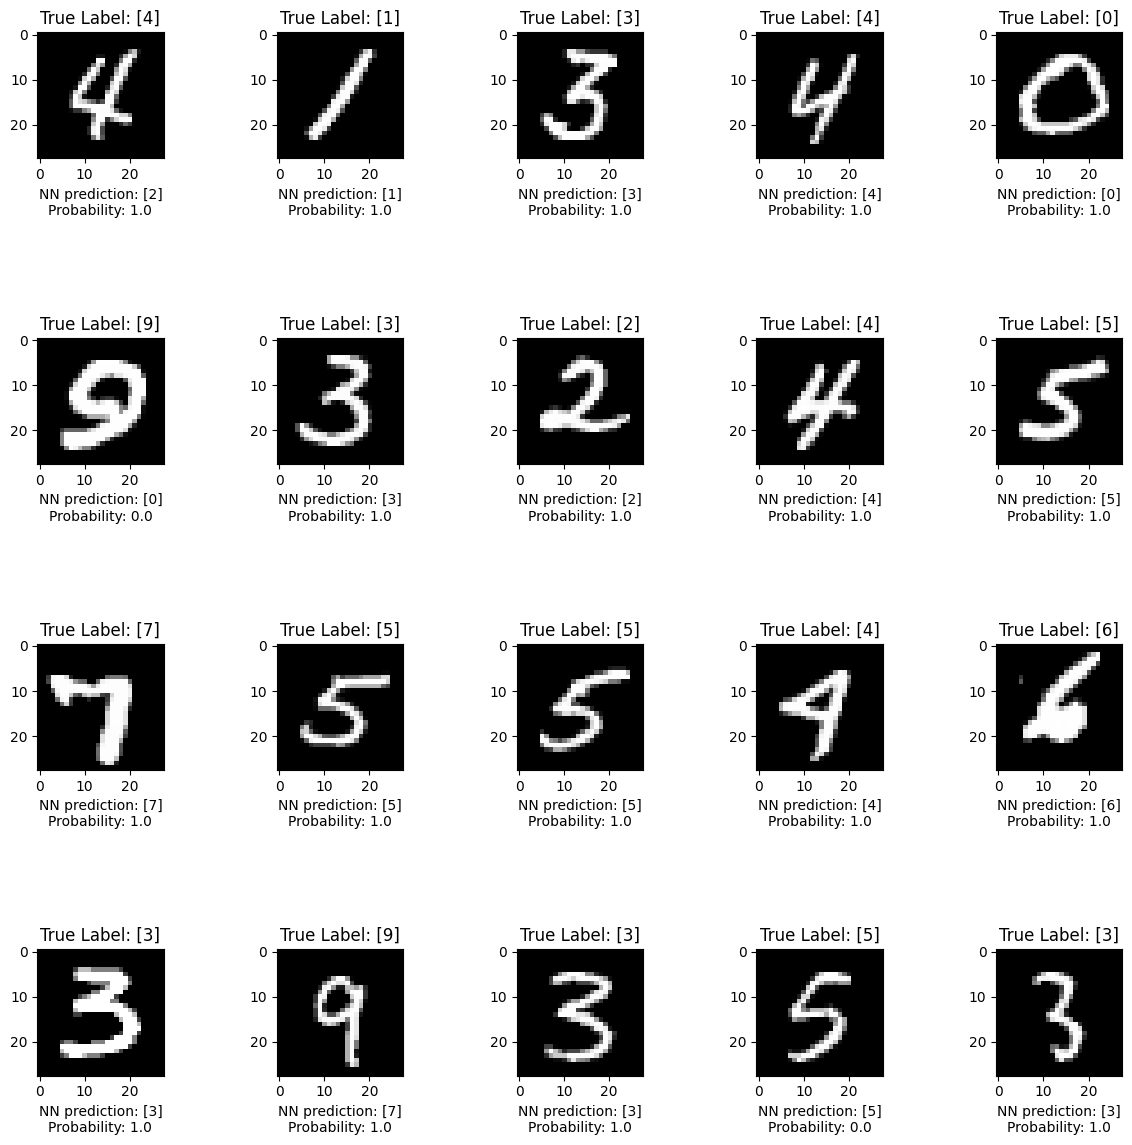

In [124]:
# View random samples and predictions
display_digits(model, X_test, y_test, 20)

# 5. Save Model (Optional)

In [125]:
# [Test] Save model
NetworkConfigHandler.store_network_config(model, 'test')

Preparing Neural Network data for storage...
Saving data...
Neural Network data stored successfully!


In [126]:
# [Test] Load model
test_model = NetworkConfigHandler.load_network_config('test')

Loading Neural Network data...
Re-constructing Neural Network with loaded data...
Neural Network re-constructed and ready for usage!


In [127]:
# Select random test sample
random_idx = random.randint(0, len(test_ds) - 1)
x_t, y_t = test_ds[random_idx]

In [128]:
# [Test] Generate prediction for random sample
pred_y_t = test_model(x_t)

In [132]:
# View prediction for random sample
print(f'y_t:\t\t{np.argmax(y_t)}')
print(f'prediction:\t{np.argmax(pred_y_t)}')
print(f'probabilities:\t{np.squeeze(pred_y_t)}')

y_t:		0
prediction:	0
probabilities:	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
